# Saliency Map
We compute the saliency map on the same image.

Note to self: run `CUDA_VISIBLE_DEVICES=1 jupyter notebook` to launch this in order to compute sal maps for (2048,2048,4) images directly (no crops).

In [2]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import georaster
import torch
import json
from pytorch_utils.eval import read_model, predict, flip
from pytorch_utils.loss import dice
from nbutils import thresh, score_pred, load_img, make_input_tensor
from config import Config
%matplotlib inline

In [3]:
indir = '../../Train/Inputs/'
truthdir = '../../Train/GT/'
fname = 'TAM_Tile_099_RGB.tif'

img = load_img(indir + fname) / 255.0
geo_img = georaster.SingleBandRaster(truthdir + fname.replace("RGB", "GTL"))
lbl = geo_img.r
lbl = thresh((lbl - 2) * 255) / 255.0
dsm = georaster.SingleBandRaster(indir + fname.replace("RGB", "DSM"))
dtm = georaster.SingleBandRaster(indir + fname.replace("RGB", "DTM"))
dem = (dsm.r - dtm.r) / 9.0
del(dsm, dtm)

In [4]:
cfg = Config(**json.load(open('../resnet34_1x1080_retrain.json', 'r')))
model = read_model(cfg, 4)

## Constructing the Saliency Map

Here we construct a saliency map for a (2048, 2048, 4) image by obtaining the saliency map for 4 (1024, 1024, 4) maps, in the shape of a window. We then piece the tensors back together to obtain the map. Note that the actual saliency map is (2048, 2048, 4), but we are condensing to (2048, 2048) by taking the max of absolute values at each pixel.

In [5]:
input_tensor = torch.Tensor(make_input_tensor(img, dem))

def get_saliency(model, input_tensor, truth, verbose=False):
    """Backpropagates loss to input and returns absolute value of the input gradient
    
    Meant for input_tensors of size <= [4, 1024, 1024]"""
    input_tensor = torch.autograd.Variable(input_tensor, requires_grad=True)
    output = torch.sigmoid(model(input_tensor.cuda()))
    loss = 1 - dice(output, torch.Tensor(truth).cuda())
    loss.backward()
    
    saliency = np.transpose(input_tensor.grad.data.cpu().numpy()[0], (1, 2, 0))
    abs_sal = np.abs(saliency).max(axis=2)
#     abs_sal = np.abs(saliency)[...,3]
    g_range = abs_sal.max() - abs_sal.min()
    abs_sal /= g_range
    if verbose:
        if truth is None:
            raise ValueError("Need to pass in truth labels in range [0, 1].")
        pred = output.detach().cpu().numpy().squeeze()
        scipy_dice = score_pred((pred*255).astype(np.uint8), truth)
        print("Torch loss:", loss, '\nDice:', scipy_dice)
    return abs_sal

def get_saliency_big(model, input_tensor, truth, verbose=False):
    """Takes in input tensor of size [4, 2048, 2048]"""
    step = 1024
    preds = []
    for x in [0, step]:
        for y in [0, step]:
            preds.append(get_saliency(model, input_tensor[:, :, x:x+step, y:y+step],
                                     truth[x:x+step, y:y+step]))
    ul, ur, ll, lr = preds
    # Reconstruct from smaller portions
    up = np.concatenate((ul, ur), axis=1)
    down = np.concatenate((ll, lr), axis=1)
    saliency = np.concatenate((up, down), axis=0)
    return saliency

### Plot Saliency Map

Since the saliency map is not very opinionated on its inputs, we include thresholded versions of the saliency map, where 

/home/ngundotra/.conda/envs/gdal/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


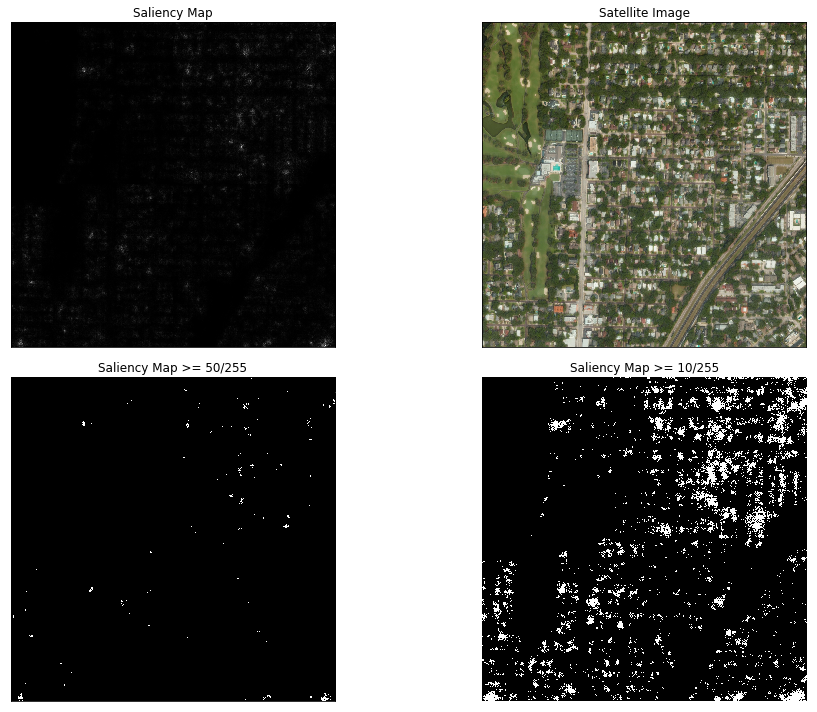

In [6]:
def plot_saliency(sal, img, thresh=[127, 10]):
    fig, ax = plt.subplots(ncols=2,figsize=(15,10), nrows=2)
    plt.axis("off")
    ul, ur = ax[0]
    ll, lr = ax[1]
    ul.imshow(sal, cmap='gray')
    ul.set_title("Saliency Map")
    ur.imshow(img)
    ur.set_title("Satellite Image")

    ll.imshow(cv2.threshold(sal,thresh[0],255,0)[1], cmap='gray')
    ll.set_title(f"Saliency Map >= {thresh[0]}/255")
    lr.imshow(cv2.threshold(sal,thresh[1],255,0)[1], cmap='gray')
    lr.set_title(f"Saliency Map >= {thresh[1]}/255")

    for a in [ul, ur, ll, lr]:
        a.set_xticks([])
        a.set_yticks([])
    fig.tight_layout()
    return fig, ax
sal = (255 * get_saliency_big(model, input_tensor, lbl)).astype(np.uint8)
fig, ax = plot_saliency(sal, img, thresh=[50, 10])